# Ultrasound Image Augmentations

In [7]:
%matplotlib widget

import random

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import skimage

from usaugment.albumentations import (
    DepthAttenuation,
    GaussianShadow,
    HazeArtifact,
    SpeckleReduction,
)

IMAGE_PATH = "byra2018_liver_ultrasound.png"
SCAN_MASK_PATH = "byra2018_liver_ultrasound_mask.png"

## Depth Attenuation

interactive(children=(FloatSlider(value=2.0, description='attenuation_rate', max=3.0), FloatSlider(value=0.0, …

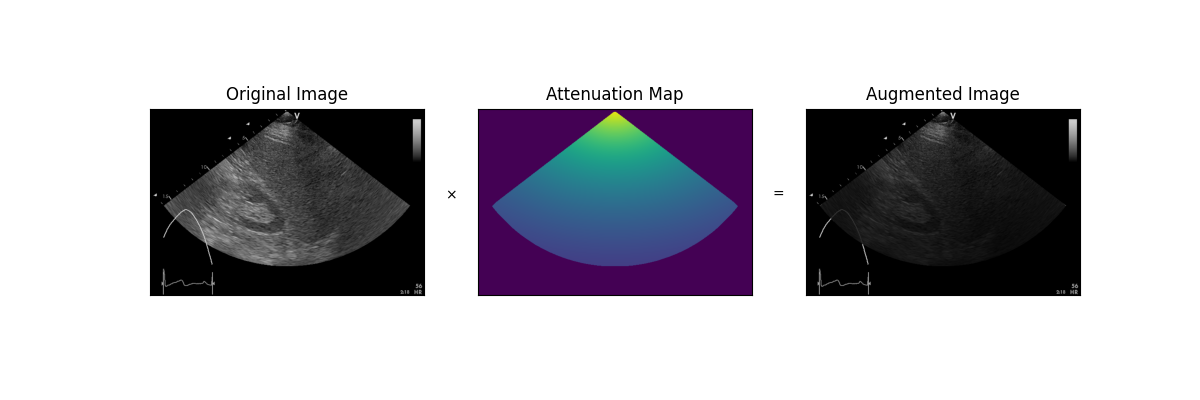

In [8]:
image = skimage.io.imread(IMAGE_PATH) / 255.0
image = np.stack([image, image, image], axis=-1)
scan_mask = skimage.io.imread(SCAN_MASK_PATH)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

axes[0].set_title("Original Image")
axes[1].set_title("Attenuation Map")
axes[1].set_ylabel("×", rotation=0, labelpad=20)
axes[2].set_title("Augmented Image")
axes[2].set_ylabel("=", rotation=0, labelpad=20)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].imshow(image, cmap="gray", vmin=0, vmax=1)
attenuation_map_ax = axes[1].imshow(np.ones_like(image), vmin=0, vmax=1)
augmented_ax = axes[2].imshow(image, cmap="gray", vmin=0, vmax=1)


@widgets.interact(attenuation_rate=(0.0, 3.0, 0.1), max_attenuation=(0.0, 1.0, 0.1))
def update(attenuation_rate=2.0, max_attenuation=0.0):  # noqa: F811
    augmentation = DepthAttenuation(
        attenuation_rate=attenuation_rate, max_attenuation=max_attenuation, p=1.0
    )
    augmented_image = augmentation.apply(img=image, scan_mask=scan_mask)
    attenuation_map = augmentation._generate_attenuation_map(
        *image.shape[:2], scan_mask=scan_mask
    )

    attenuation_map_ax.set_data(attenuation_map)
    augmented_ax.set_data(augmented_image)

### Visualize Exponential Decay

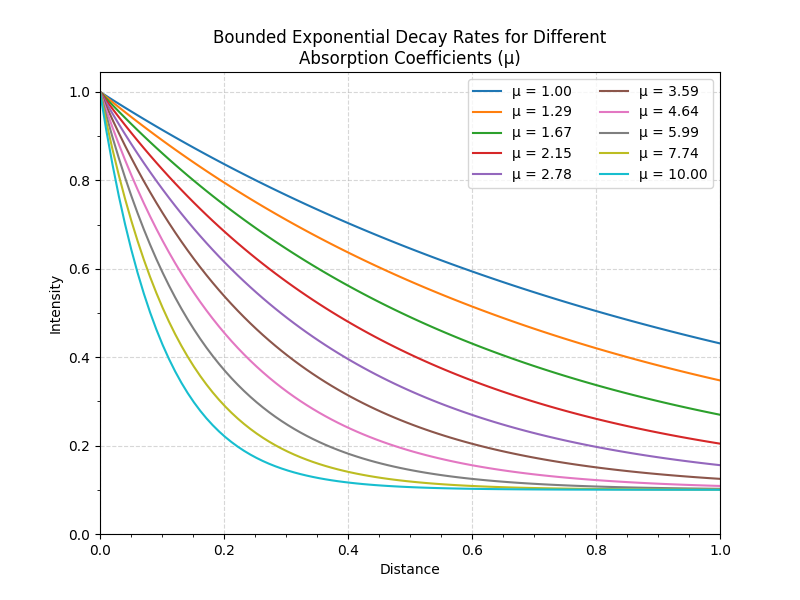

In [9]:
def bounded_exponential_decay(attenuation_rate, distance, lower_bound=0):
    """Calculate the intensity of the beam after a given distance using the exponential
    decay formula. The intensity is bounded between the lower bound and 1.0
    """
    intensity = (1 - lower_bound) * np.exp(-attenuation_rate * distance) + lower_bound
    return intensity


attenuation_rates = np.logspace(start=0, stop=1, num=10)

fig, ax = plt.subplots(figsize=(8, 6))

distance = np.linspace(0, 1, 100)
for attenuation_rate in attenuation_rates:
    intensity = bounded_exponential_decay(0.5, distance, lower_bound=0.1)
    plt.plot(
        distance,
        bounded_exponential_decay(attenuation_rate, distance, lower_bound=0.1),
        label=f"μ = {attenuation_rate:.2f}",
    )

plt.xticks(np.arange(0, 1.05, 0.05), minor=True)
plt.yticks(np.arange(0, 1.1, 0.1), minor=True)
plt.xlabel("Distance")
plt.xlim(0, 1)
plt.ylabel("Intensity")
plt.grid(which="major", linestyle="--", alpha=0.5)
plt.title("Bounded Exponential Decay Rates for Different\nAbsorption Coefficients (μ)")
plt.legend(ncols=2)
plt.savefig("../figures/depth_attenuation_exponential_decay.svg")
plt.show()

## Haze Artifact

interactive(children=(FloatSlider(value=0.5, description='radius', max=1.0, step=0.05), FloatSlider(value=0.1,…

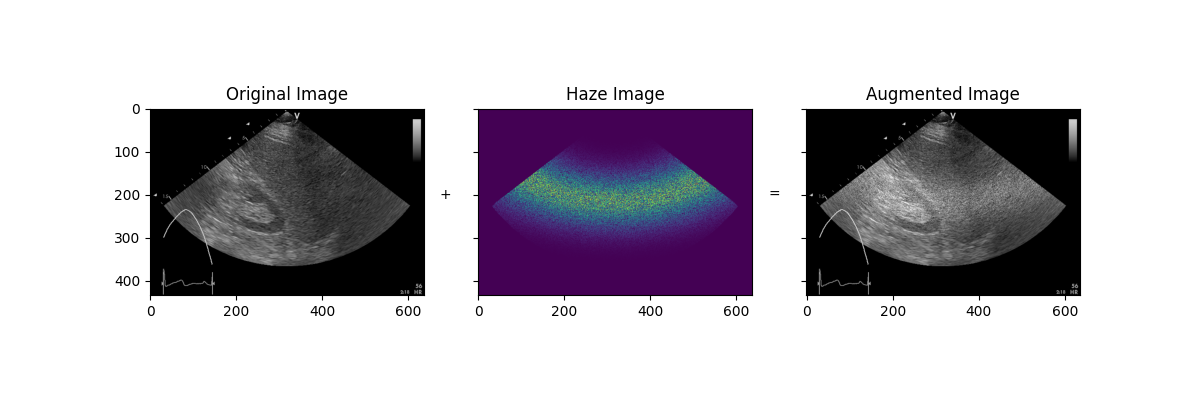

In [10]:
image = skimage.io.imread(IMAGE_PATH) / 255.0
image = np.stack([image, image, image], axis=-1)
scan_mask = skimage.io.imread(SCAN_MASK_PATH)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

axes[0].set_title("Original Image")
axes[1].set_title("Haze Image")
axes[1].set_ylabel("+", rotation=0, labelpad=20)
axes[2].set_title("Augmented Image")
axes[2].set_ylabel("=", rotation=0, labelpad=20)

axes[0].imshow(image, cmap="gray", vmin=0, vmax=1)
haze_image_ax = axes[1].imshow(np.ones_like(image), vmin=0, vmax=1)
augmented_ax = axes[2].imshow(image, cmap="gray", vmin=0, vmax=1)


@widgets.interact(radius=(0.0, 1.0, 0.05), sigma=(0.001, 0.5, 0.05))
def update(radius=0.5, sigma=0.1):  # noqa: F811
    augmentation = HazeArtifact(radius=radius, sigma=sigma, p=1.0)
    augmented_image = augmentation.apply(img=image, scan_mask=scan_mask)
    haze_image = augmentation._generate_haze(*image.shape[:2])
    haze_image = haze_image * scan_mask

    haze_image_ax.set_data(haze_image)
    augmented_ax.set_data(augmented_image)

## Gaussian Shadow

interactive(children=(FloatSlider(value=0.5, description='strength', max=1.0, step=0.05), FloatSlider(value=0.…

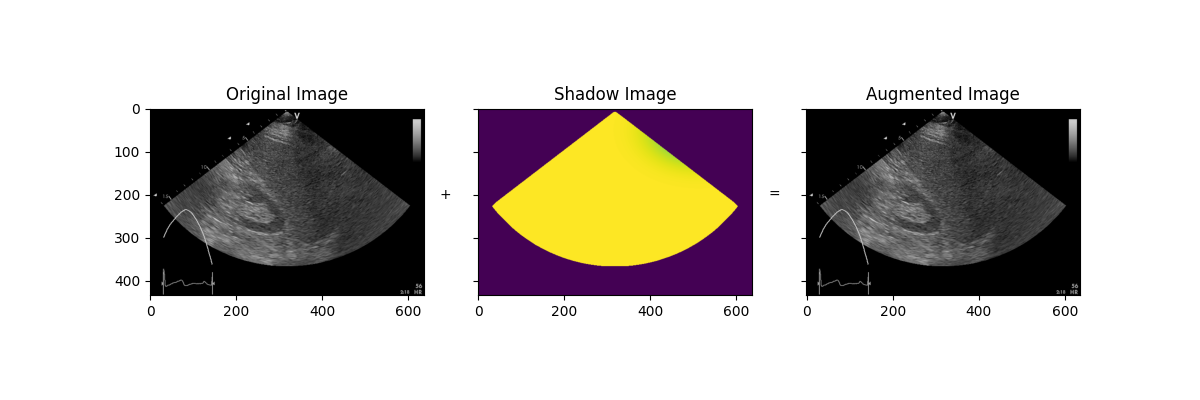

In [11]:
image = skimage.io.imread(IMAGE_PATH) / 255.0
image = np.stack([image, image, image], axis=-1)
scan_mask = skimage.io.imread(SCAN_MASK_PATH)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

axes[0].set_title("Original Image")
axes[1].set_title("Shadow Image")
axes[1].set_ylabel("+", rotation=0, labelpad=20)
axes[2].set_title("Augmented Image")
axes[2].set_ylabel("=", rotation=0, labelpad=20)

axes[0].imshow(image, cmap="gray", vmin=0, vmax=1)
shadow_image_ax = axes[1].imshow(np.ones_like(image), vmin=0, vmax=1)
augmented_ax = axes[2].imshow(image, cmap="gray", vmin=0, vmax=1)


@widgets.interact(
    strength=(0.0, 1.0, 0.05), sigma_x=(0.01, 0.4, 0.05), sigma_y=(0.01, 0.4, 0.05)
)
def update(strength=0.5, sigma_x=0.1, sigma_y=0.1):  # noqa: F811
    augmentation = GaussianShadow(
        strength=strength, sigma_x=sigma_x, sigma_y=sigma_y, p=1.0
    )

    seed = random.randint(0, 100)

    np.random.seed(seed)
    augmented_image = augmentation.apply(img=image, scan_mask=scan_mask)

    np.random.seed(seed)
    shadow_image = augmentation._generate_shadow_image(
        image.shape[0], image.shape[1], scan_mask=scan_mask
    )

    shadow_image_ax.set_data(shadow_image)
    augmented_ax.set_data(augmented_image)

## Speckle Reduction

interactive(children=(FloatSlider(value=0.5, description='sigma_spatial', max=1.0, min=0.05, step=0.05), Float…

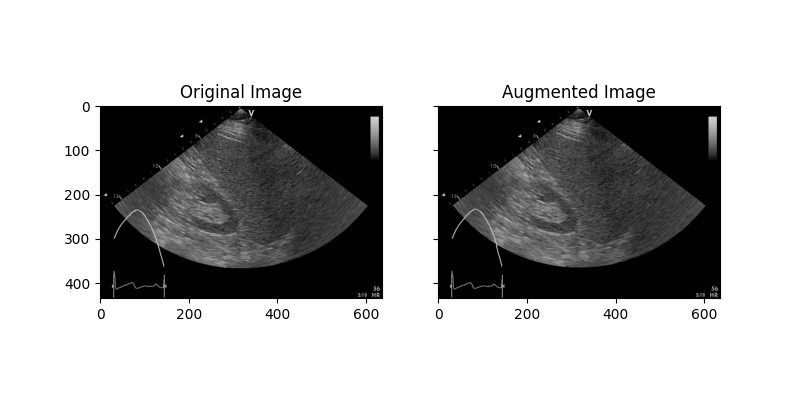

In [12]:
image = skimage.io.imread(IMAGE_PATH) / 255.0
image = np.stack([image, image, image], axis=-1)
scan_mask = skimage.io.imread(SCAN_MASK_PATH)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 4))

axes[0].set_title("Original Image")
axes[1].set_title("Augmented Image")

axes[0].imshow(image, cmap="gray", vmin=0, vmax=1)
augmented_ax = axes[1].imshow(image, cmap="gray", vmin=0, vmax=1)


@widgets.interact(sigma_spatial=(0.05, 1.0, 0.05), sigma_color=(0.05, 1.0, 0.05))
def update(sigma_spatial=0.5, sigma_color=0.5):  # noqa: F811
    augmentation = SpeckleReduction(
        sigma_spatial=sigma_spatial, sigma_color=sigma_color, window_size=5, p=1.0
    )
    augmented_image = augmentation.apply(img=image, scan_mask=scan_mask)
    augmented_ax.set_data(augmented_image)